<a href="https://colab.research.google.com/github/joelkowalewski/teaching/blob/main/Corrected_stable_smooth_infinite_zoom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A user friendly colab notebook to generate infinite loop videos in minutes (works on free colab plan)

#### Examples and latest version available here:  
https://colab.research.google.com/github/v8hid/infinite-zoom-stable-diffusion/blob/main/smooth_infinite_zoom.ipynb

In [1]:
#@markdown CHECK TYPE OF GPU AND VRAM AVAILABLE   <br>
#@markdown The notebook should work fine with the Tesla T4 GPU + 16 GB VRAM available (but to a limited extend) in the free colab plan. <br>
#@markdown If this drops an error you need go: Runtime / Change runtime type and pick Hardvare accelarator = GPU and GPU class = Standard.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15101 MiB


In [2]:
#@markdown **Static setting**
from google.colab import drive
from types import SimpleNamespace

def Static():
    mount_google_drive = True #@param {type:"boolean"}
    if (mount_google_drive) :
      drive.mount('/content/gdrive')
    output_path = "/content/gdrive/MyDrive/infinite-zoom" #@param {type:"string"}
    return locals()

static = Static()
static = SimpleNamespace(**static)

Mounted at /content/gdrive


In [3]:
#@markdown SET UP ENVIRONMENT

print("1/3: Install missing libraries")
%pip install -qq transformers scipy ftfy accelerate
%pip install -qq --upgrade diffusers[torch]

print("2/3: Load necessary libraries")
import PIL
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import random
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
from diffusers import StableDiffusionInpaintPipeline, EulerAncestralDiscreteScheduler
from IPython.display import clear_output
from datetime import datetime
if not os.path.exists(static.output_path):
    os.makedirs(static.output_path)
print("3/3: Define helper functions")
def write_video(file_path, frames, fps, reversed = True, start_frame_dupe_amount = 15, last_frame_dupe_amount = 30):
  """
  Writes frames to an mp4 video file
  :param file_path: Path to output video, must end with .mp4
  :param frames: List of PIL.Image objects
  :param fps: Desired frame rate
  :param reversed: if order of images to be reversed (default = True)
  """
  if reversed == True:
    frames.reverse()

  w, h = frames[0].size
  fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
  #fourcc = cv2.VideoWriter_fourcc('h', '2', '6', '4')
  #fourcc = cv2.VideoWriter_fourcc(*'avc1')
  writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))

## start frame duplicated
  for x in range(start_frame_dupe_amount):
    np_frame = np.array(frames[0].convert('RGB'))
    cv_frame = cv2.cvtColor(np_frame, cv2.COLOR_RGB2BGR)
    writer.write(cv_frame)

  for frame in frames:
      np_frame = np.array(frame.convert('RGB'))
      cv_frame = cv2.cvtColor(np_frame, cv2.COLOR_RGB2BGR)
      writer.write(cv_frame)

## last frame duplicated
  for x in range(last_frame_dupe_amount):
    np_frame = np.array(frames[len(frames) - 1].convert('RGB'))
    cv_frame = cv2.cvtColor(np_frame, cv2.COLOR_RGB2BGR)
    writer.write(cv_frame)

  writer.release()

def image_grid(imgs, rows, cols):
  assert len(imgs) == rows*cols

  w, h = imgs[0].size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

def shrink_and_paste_on_blank(current_image, mask_width):
  """
  Decreases size of current_image by mask_width pixels from each side,
  then adds a mask_width width transparent frame,
  so that the image the function returns is the same size as the input.
  :param current_image: input image to transform
  :param mask_width: width in pixels to shrink from each side
  """

  height = current_image.height
  width = current_image.width

  #shrink down by mask_width
  prev_image = current_image.resize((height-2*mask_width,width-2*mask_width))
  prev_image = prev_image.convert("RGBA")
  prev_image = np.array(prev_image)

  #create blank non-transparent image
  blank_image = np.array(current_image.convert("RGBA"))*0
  blank_image[:,:,3] = 1

  #paste shrinked onto blank
  blank_image[mask_width:height-mask_width,mask_width:width-mask_width,:] = prev_image
  prev_image = Image.fromarray(blank_image)

  return prev_image

def load_img(address, res=(512, 512)):
    if address.startswith('http://') or address.startswith('https://'):
        image = Image.open(requests.get(address, stream=True).raw)
    else:
        image = Image.open(address)
    image = image.convert('RGB')
    image = image.resize(res, resample=Image.LANCZOS)
    return image



1/3: Install missing libraries
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.0 MB/s eta 0:00:00
2/3: Load necessary libraries


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

3/3: Define helper functions


In [4]:
#@markdown DOWNLOAD MODEL WEIGHTS AND SET UP DIFFUSION PIPELINE <br><br>
#@markdown Pick your favourite inpainting model:
model_id = 'stabilityai/stable-diffusion-2-inpainting' #@param ["stabilityai/stable-diffusion-2-inpainting", "runwayml/stable-diffusion-inpainting", "ImNoOne/f222-inpainting-diffusers","parlance/dreamlike-diffusion-1.0-inpainting","ghunkins/stable-diffusion-liberty-inpainting"] {allow-input: true}
pipe = StableDiffusionInpaintPipeline.from_pretrained(
      model_id,
      torch_dtype=torch.float16,
  )
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

pipe.safety_checker = None
pipe.enable_attention_slicing()
g_cuda = torch.Generator(device='cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
prompts={
    0: "metropolis cybernetic cyberpunk snowcrash neuromancer soft pastel colors, wizarth, imagevectorism, portrait, Gothic Art by Kenny Schink, Softcore watercolor DEMONIC Messiah MEDUSA statue ARTFULL colors Instagram trending ARTstation beautiful symmetric symmetry horrifically brutal",
    7: "Ultra realistic astronaut on the beach fantastically detailed reflecting eyes modern anime style art massive detailed built-in firearms wolfmask cyborg male leather jacket suit, beam sword, missile, shoulder cannon, four arms, vtuber cyberpunk,"
}

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


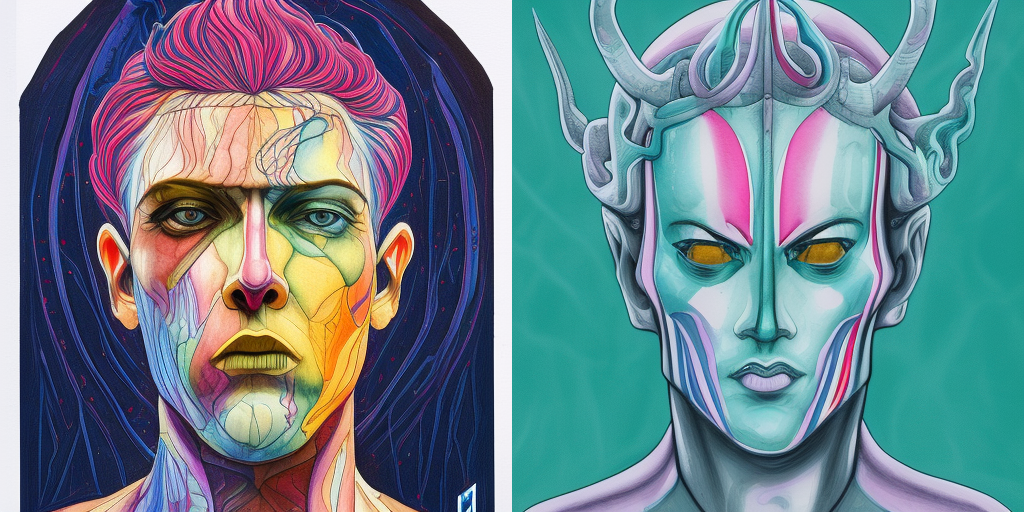

In [6]:
#@markdown FIND A GOOD CONCEPT FOR YOUR VIDEO: <br>
#@markdown (Image output of this block will be the last image of the video)

prompt = prompts[0]
negative_prompt = "montage, frame, text, ugly, blur" #@param {type:"string"}

#@markdown Number of initial example images to generate:
num_init_images = 2 #@param
#@markdown Random seed (arbitrary input to make the initial image generation deterministic):
seed = 9999 #@param
#@markdown  The number of denoising steps (Higher number usually lead to a higher quality image at the expense of slower inference):
num_inference_steps = 30 #@param
#@markdown Guidance scale defines how closely generated images to be linked to the text prompt:
guidance_scale = 6 #@param
#@markdown Heigth (and width) of the images in pixels (= resolution of the video generated in the next block, has to be divisible with 8):
height = 512 #@param
width = height
#@markdown Since the model was trained on 512 images increasing the resolution to e.g. 1024 will
#@markdown drastically reduce its imagination, so the video will vary a lot less compared to 512

current_image = PIL.Image.new(mode="RGBA", size=(height, width))
mask_image = np.array(current_image)[:,:,3]
mask_image = Image.fromarray(255-mask_image).convert("RGB")
current_image = current_image.convert("RGB")

init_images =  pipe(prompt=[prompt]*num_init_images,
                    negative_prompt=[negative_prompt]*num_init_images,
                    image=current_image,
                    guidance_scale = guidance_scale,
                    height = height,
                    width = width,
                    generator = g_cuda.manual_seed(seed),
                    mask_image=mask_image,
                    num_inference_steps=num_inference_steps)[0]


image_grid(init_images, rows=1, cols=num_init_images)

[f.save(f'/content/gdrive/MyDrive/infinite-zoom/image{i+1}.jpeg')for  i, f in enumerate(init_images)]

We shrink the init image from the previous block and outpaint its outer frame using the same concept defined above (e.g. prompt, negative prompt, inference steps) but with a different seed. To generate an "inifinte zoom" video this is repeated **num_outpainting_steps** times and then rendered in reversed order.  
  
To keep the outpainted part coherent and full of new content its width has to be relatively large (e.g. **mask_width** = 128 pixels if resolution is 512*512).
   
This on the other hand means that the generated video would be too fast and aestetically unpleasant. To slow down and smoothen the video we generate **num_interpol_frames** additional images between outpainted images using simple "interpolation".    

Notes:    

 - Length of the video is proportional to num_outpainting_steps * num_interpol_frames.   
 - The time to generate the video is proportional to num_outpainting_steps.  
 - On a T4 GPU it takes about ~7 minutes to generate the video of width = 512, num_inference_steps = 20, num_outpainting_steps = 100. With fps = 24 and num_interpol_frames = 24 the video will be about 1:40 minutes long.


In [14]:
#@markdown GENERATE VIDEO:  <br> <br>

#@markdown Pick an initial image from the previous block for your video: <br> (This is only relevant if num_init_images > 1)
init_image_selected = 1 #@param
if num_init_images == 1:
  init_image_selected = 0
else:
  init_image_selected = init_image_selected - 1
custom_init_image = True #@param {type:"boolean"}
init_image_address = "/content/gdrive/MyDrive/infinite-zoom/image1.jpeg"#@param {type:"string"}
#@markdown Number of outpainting steps:
num_outpainting_steps = 20 #@param
#@markdown Width of the border in pixels to be outpainted during each step:
#@markdown <br> (make sure: mask_width < image resolution / 2)
mask_width = 128 #@param
#@markdown Number of images to be interpolated between each outpainting step:
num_interpol_frames = 30 #@param

if(custom_init_image):
  current_image = load_img(init_image_address,(width,height))
else :
  current_image = init_images[init_image_selected]
all_frames = []
all_frames.append(current_image)

for i in range(num_outpainting_steps):
  print('Generating image: ' + str(i+1) + ' / ' + str(num_outpainting_steps))

  prev_image_fix = current_image

  prev_image = shrink_and_paste_on_blank(current_image, mask_width)

  current_image = prev_image

  #create mask (black image with white mask_width width edges)
  mask_image = np.array(current_image)[:,:,3]
  mask_image = Image.fromarray(255-mask_image).convert("RGB")

  #inpainting step
  current_image = current_image.convert("RGB")
  images = pipe(prompt=prompts[max(k for k in prompts.keys() if k <= i)],
                negative_prompt=negative_prompt,
                image=current_image,
                guidance_scale = guidance_scale,
                height = height,
                width = width,
                #this can make the whole thing deterministic but the output less exciting
                #generator = g_cuda.manual_seed(seed),
                mask_image=mask_image,
                num_inference_steps=num_inference_steps)[0]
  current_image = images[0]
  current_image.paste(prev_image, mask=prev_image)

  #interpolation steps bewteen 2 inpainted images (=sequential zoom and crop)
  for j in range(num_interpol_frames - 1):
    interpol_image = current_image
    interpol_width = round(
        (1- ( 1-2*mask_width/height )**( 1-(j+1)/num_interpol_frames ) )*height/2
        )
    interpol_image = interpol_image.crop((interpol_width,
                                          interpol_width,
                                          width - interpol_width,
                                          height - interpol_width))

    interpol_image = interpol_image.resize((height, width))

    #paste the higher resolution previous image in the middle to avoid drop in quality caused by zooming
    interpol_width2 = round(
        ( 1 - (height-2*mask_width) / (height-2*interpol_width) ) / 2*height
        )
    prev_image_fix_crop = shrink_and_paste_on_blank(prev_image_fix, interpol_width2)
    interpol_image.paste(prev_image_fix_crop, mask = prev_image_fix_crop)

    all_frames.append(interpol_image)

  all_frames.append(current_image)
  clear_output(wait=True)
  interpol_image.show()

Generating image: 20 / 20


  0%|          | 0/30 [00:00<?, ?it/s]

In [15]:
#@markdown RENDER THE GENERATED FRAMES INTO AN MP4 VIDEO.
video_file_name = "infinite_zoom" #@param {type:"string"}
#@markdown frames per second:
fps = 30 #@param
now = datetime.now()
date_time = now.strftime("%m-%d-%Y_%H-%M-%S")
#@markdown Duplicates the first and last frames, use to add a delay before animation based on playback fps (15 = 0.5 seconds @ 30fps)
start_frame_dupe_amount = 15 #@param
last_frame_dupe_amount = 15 #@param
write_video(os.path.join(static.output_path, video_file_name + "_out_"+date_time+".mp4"), all_frames, fps, False, start_frame_dupe_amount, last_frame_dupe_amount)
write_video(os.path.join(static.output_path, video_file_name + "_in_"+date_time+".mp4"), all_frames, fps, True, start_frame_dupe_amount, last_frame_dupe_amount)
#@markdown Once this block is finished, download your video from the "Files" folder menu on the left (output_path).

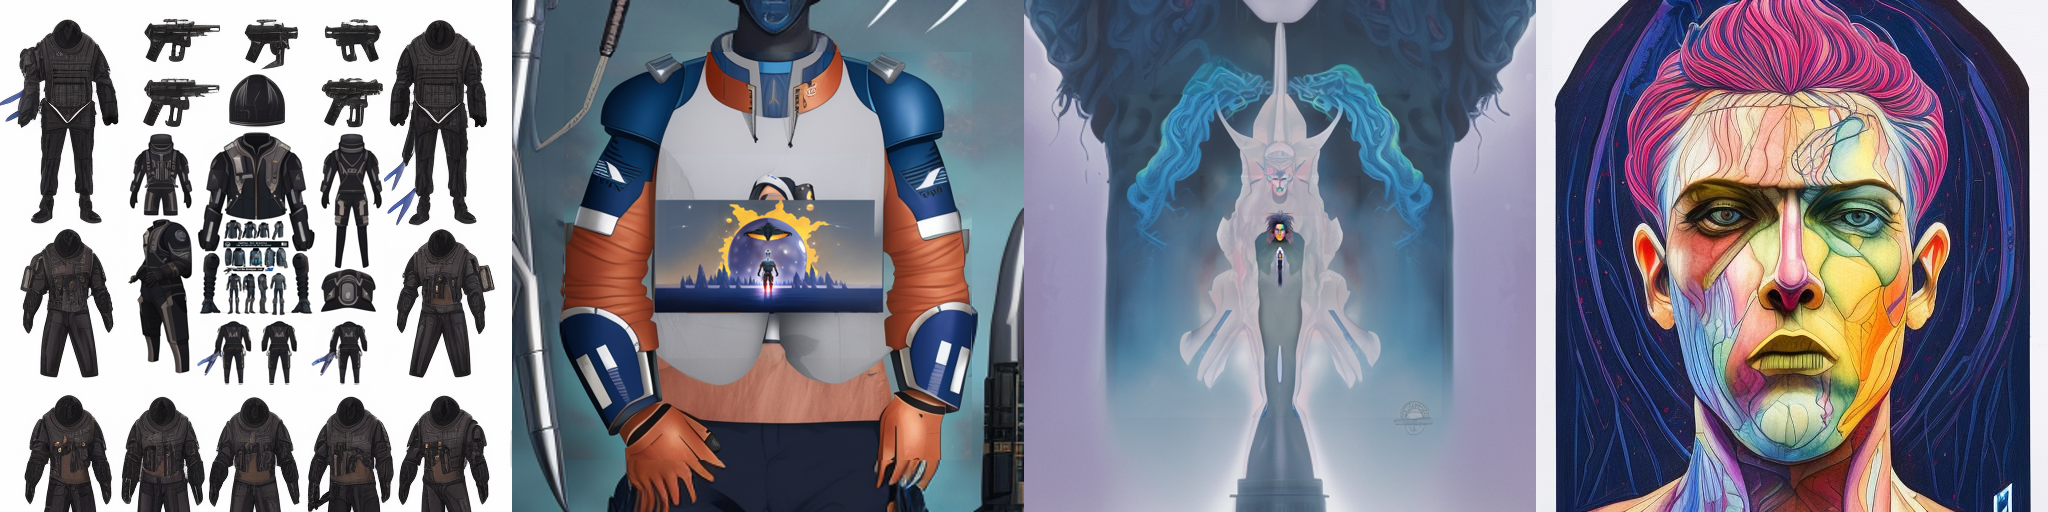

In [16]:
#@markdown CHECK SOME (equally spaced) FRAMES OF THE VIDEO:
num_of_frames_to_chk = 4 #@param
num_of_frames_to_chk = min(num_of_frames_to_chk, len(all_frames))
idx = np.round(np.linspace(0, len(all_frames) - 1, num_of_frames_to_chk)).astype(int)
image_grid(list(all_frames[i] for i in idx), rows = 1, cols = num_of_frames_to_chk)
#@markdown (This is relatively slow but still faster in some cases then to download the complete video in the previous block)
